# Source: [Andrey Kaparthy](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&ab_channel=AndrejKarpathy)

In [1]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Sequence, TypeAlias, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def f(x: int | float) -> int | float:
    """A function that generates a quadratic function."""
    result: int | float = 3 * x**2 - 4 * x + 5
    return result

In [3]:
ndArray: TypeAlias = npt.NDArray[np.int_ | np.float_]

Xs: ndArray = np.arange(-5, 5, 0.25)
Ys: ndArray = f(Xs)

Xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [4]:
Ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

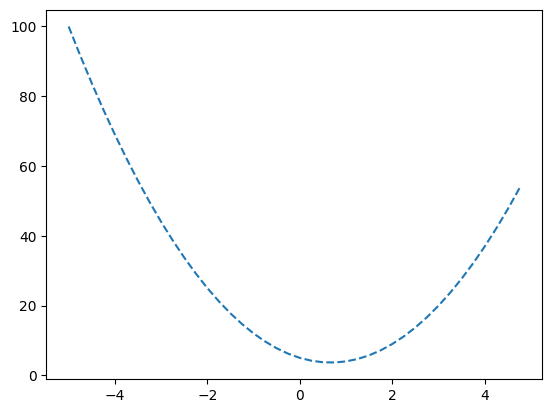

In [5]:
plt.plot(Xs, Ys, "--")
plt.show()

## Derivative

- The derivative of a function captures the idea of `instantaneous rate of change`.
- In both calculus and machine learning, it tells you how a function's output, denoted by f(x), changes with respect to its input, represented by x.

In [6]:
h: float = 0.001  # A very small number
x: float = 3.0

f(x + h)

20.014003000000002

$$ y=3x^2 -4x + 5 $$

Slope is ...

$$ slope = 6x - 4 $$

If x = 3;
$$ slope = 6(3) - 4 = 14 $$

In [7]:
# Change in value divided by run. i.e. rise per run
slope: float = (f(x + h) - f(x)) / h
slope

14.00300000000243

## Micro Grad Implementation

In [8]:
class Value:

    def __init__(
        self,
        data: int | float,
        _children: tuple[Any] = (),
        _op: str = "",
        label: str = "",
    ) -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0  # No gradient yet

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(data={self.data})"

    def __add__(self, other: "Value") -> "Value":
        """Addition of two values."""
        other = other if isinstance(other, Value) else Value(other)
        return Value(self.data + other.data, (self, other), "+")

    def __mul__(self, other: "Value") -> "Value":
        """Multiplication of two values."""
        other = other if isinstance(other, Value) else Value(other)
        return Value(self.data * other.data, (self, other), "*")

    def tanh(self) -> "Value":
        """Hyperbolic tangent of value."""
        x: int | float = self.data
        tanh = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
        return Value(tanh, _children=(self,), _op="tanh")

In [9]:
a = Value(data=2, label="a")
b = Value(data=6, label="b")

a, b

(Value(data=2), Value(data=6))

In [10]:
c = a + b
c.label = "c"
d = a * b
d.label = "d"

c._prev, d._prev

({Value(data=2), Value(data=6)}, {Value(data=2), Value(data=6)})

In [11]:
c._op, d._op

('+', '*')

In [12]:
# pip install graphviz or brew install graphviz
# Copied!!!
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format="svg", rankdir="LR"):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ["LR", "TB"]
    nodes, edges = trace(root)
    dot = Digraph(
        format=format, graph_attr={"rankdir": rankdir}
    )  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(
            name=str(id(n)),
            # label="{ data %.4f | grad %.4f }" % (n.data, n.grad),
            label="{ %s | data %.4f | grad %.4f  }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

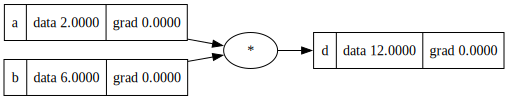

In [13]:
draw_dot(d)

In [14]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")

# Forward pass
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"
L

Value(data=-8.0)

## To Do

- Derive the derivatives:
  - dL / dL
  - dL / dd
  - dL / df
  - dL / dc
  - dL / de
  - dL / da
  - dL / db


### 1. dL / dL

$$ \frac{dL}{dL} = 1 $$

### 2. dL / dd

$$ L = d * f $$
$$ \frac{dL}{dd} = \frac{ (f(x + h) - f(x) )}{h} $$
$$ \frac{dL}{dd} = \frac{ ((d+h)*f - (d*f) )}{h} $$
$$ \frac{dL}{dd} = \frac{ (d*f + h*f - d*f )}{h} $$
$$ \frac{dL}{dd} = f $$

### 3. dL / df

$$ L = d * f $$
$$ \frac{dL}{df} = \frac{ (f(x + h) - f(x) )}{h} $$
$$ \frac{dL}{df} = \frac{ (d*(f+h) - (d*f) )}{h} $$
$$ \frac{dL}{df} = d $$

### 4. dL / dc

$$ d = c + e $$
Local derivative
$$ \frac{dd}{dc} = 1 $$
Overall derivative
$$ \frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc} $$
$$ \frac{dL}{dc} = f * 1 $$

### 5. dL / de

$$ d = c + e $$
Local derivative
$$ \frac{dd}{de} = 1 $$
Overall derivative
$$ \frac{dL}{de} = \frac{dL}{dd} * \frac{dd}{de} $$
$$ \frac{dL}{de} = f * 1 $$

### 6. dL / da

$$ e = a * b $$
Local derivative
$$ \frac{de}{da} = b $$
Overall derivative
$$ \frac{dL}{da} = \frac{dL}{de} * \frac{de}{da} $$
$$ \frac{dL}{da} = f * b $$

### 7. dL / db

$$ e = a * b $$
Local derivative
$$ \frac{de}{db} = a $$
Overall derivative
$$ \frac{dL}{db} = \frac{dL}{de} * \frac{de}{db} $$
$$ \frac{dL}{db} = f * a $$

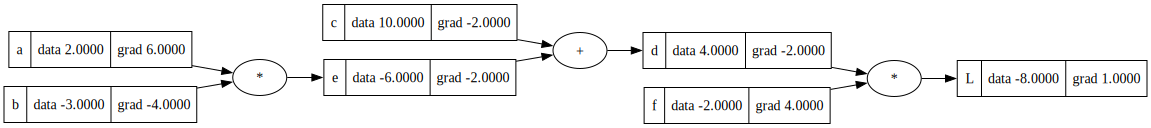

In [15]:
L.grad = 1.0  # base case
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

draw_dot(L)

In [16]:
def manual_derivative() -> Any:
    """This is used to manually calculate the derivative of a function."""
    h: float = 0.0001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")

    # Forward pass
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L1 = L.data

    a = Value(2.0, label="a")
    a += h
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")

    # Forward pass
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L2 = L.data

    deriv: float = (L2 - L1) / h
    console.print(f"{deriv=:4f}")

In [17]:
manual_derivative()

deriv=6.000000

In [18]:
# Simulate an optimization/reduction of the loss
# i.e. add the gradients to the `leaf` nodes.
step: float = 0.01
a.data += step * a.grad
b.data += step * b.grad
c.data += step * c.grad
f.data += step * f.grad

# Forward pass
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"
L  # From -8.0 to -7.44

Value(data=-7.4352)

## BackProp In Multi-Layer Perceptron (MLP)

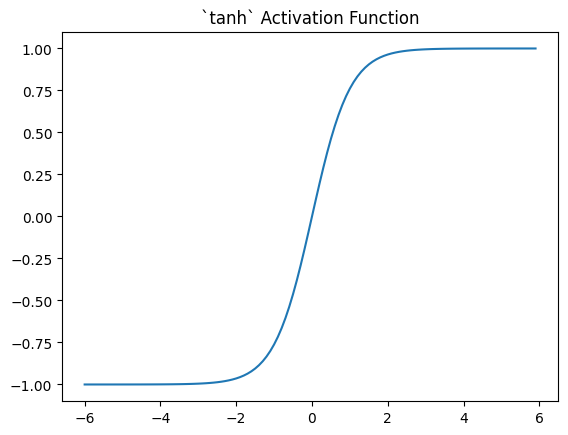

In [19]:
# Tanh activation function
X: ndArray = np.arange(-6, 6, 0.1)
Y: ndArray = np.tanh(X)

plt.plot(X, Y)
plt.title("`tanh` Activation Function")
plt.show()

In [20]:
# Updated!
class Value:

    def __init__(
        self,
        data: int | float,
        _children: tuple[Any] = (),
        _op: str = "",
        label: str = "",
    ) -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0  # No gradient yet
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(data={self.data})"

    def __add__(self, other: "Value") -> "Value":
        """Addition of two values."""
        other = other if isinstance(other, Value) else Value(other)
        out: Value = Value(self.data + other.data, (self, other), "+")

        def _backward() -> None:
            """Closure for calculating gradient of an addition operation."""
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __mul__(self, other: "Value") -> "Value":
        """Multiplication of two values."""
        other = other if isinstance(other, Value) else Value(other)
        out: Value = Value(self.data * other.data, (self, other), "*")

        def _backward() -> None:
            """Closure for calculating gradient of a multiplication operation.
            NB: The input values are flipped because of the multiplication.
            """
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward
        return out

    def tanh(self) -> "Value":
        """Hyperbolic tangent of value."""
        x: int | float = self.data
        tanh = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
        out: Value = Value(tanh, _children=(self,), _op="tanh")

        def _backward() -> None:
            """Closure for calculating gradient of a hyperbolic tangent operation."""
            self.grad += (1 - tanh**2) * out.grad

        out._backward = _backward
        return out

<hr><br>

## Build A Simple MLP With Two Inputs

<img src="./images/neuron_model.jpeg" width="500">

In [21]:
def create_graph() -> list["Value"]:
    """This is used to create a graph of the forward pass."""
    # Inputs: x1, x2
    x1 = Value(2.0, label="x1")
    x2 = Value(0.0, label="x2")

    # Weights: w1, w2
    w1 = Value(-3.0, label="w1")
    w2 = Value(1.0, label="w2")

    # Bias of the neuron: b1
    b = Value(6.88131, label="b")

    # Forward pass: y = x1 * w1 + x2 * w2 + b
    x1w1 = x1 * w1
    x1w1.label = "x1w1"
    x2w2 = x2 * w2
    x2w2.label = "x2w2"
    sum_x1w1_x2w2 = x1w1 + x2w2
    sum_x1w1_x2w2.label = "x1w1 + x2w2"
    y = sum_x1w1_x2w2 + b
    y.label = "y"
    # Apply a squashing function to the output
    out = y.tanh()
    out.label = "out"

    return [out, y, sum_x1w1_x2w2, x1w1, x2w2, b, x1, x2, w1, w2, b]

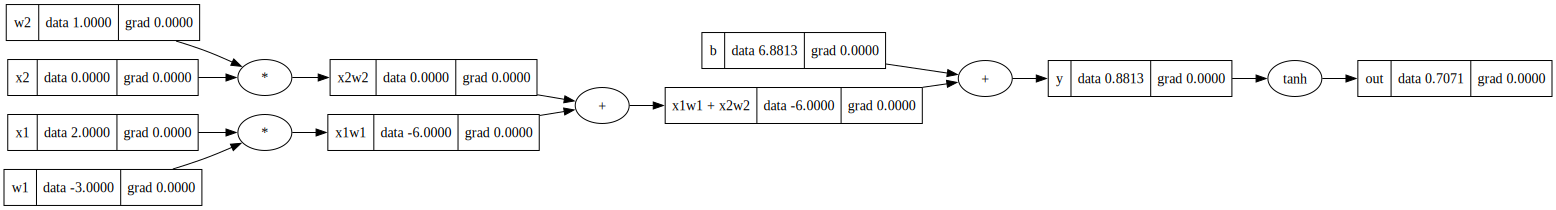

In [22]:
[out, y, sum_x1w1_x2w2, x1w1, x2w2, b, x1, x2, w1, w2, b] = create_graph()

draw_dot(out)

### Derivatives Calculations

- **Note**: The gradients of the inputs (x1, x2) are ommited since the inputs are constant and there's no need for optimizing the values.

#### 1. dout / dout

$$ out = \tanh(y) $$
$$ \frac{dout}{dout} = 1 $$

#### 2. dout / dy

$$ out = \tanh(y) $$
Chain rule
$$ \frac{dout}{dy} = \frac{dout}{dout} * \frac{dout}{dy} $$
$$ \frac{dout}{dy} = 1 * (1 - \tanh(y)^2) $$
$$ \frac{dout}{dy} = 1 - out^2 $$

#### 3. dout / (x1w1 + x2w2)

$$ y = x1*w1 + x2*w2 + b $$
Local derivative
$$ \frac{dy}{x1w1 + x2*2} = 1 $$
Overall derivative
$$ \frac{dout}{x1w1 + x2w2} = \frac{dout}{dy} * \frac{dy}{x1w1 + x2w2} $$
$$ \frac{dout}{x1w1 + x2w2} = \frac{dout}{dy} * 1 $$
$$ \frac{dout}{x1w1 + x2w2} = 1 - out^2 $$

#### 4. dout / db

$$ y = x1*w1 + x2*w2 + b $$
Local derivative
$$ \frac{dy}{b} = 1 $$
Overall derivative
$$ \frac{dout}{db} = \frac{dout}{dy} * \frac{dy}{db} $$
$$ \frac{dout}{db} = \frac{dout}{dy} * 1 $$
$$ \frac{dout}{db} = 1 - out^2 $$

#### 5. dout / d(x1w1)

$$ sumAB = x1w1 + x2w2 $$
Local derivative
$$ \frac{d(sumAB)}{d(x1w1)} = 1 $$
Overall derivative
$$ \frac{dout}{d(x1w1)} = \frac{dout}{d(sumAB)} * \frac{d(sumAB)}{d(x1w1)} $$
$$ \frac{dout}{d(x1w1)} = \frac{dout}{d(sumAB)} * 1 $$
$$ \frac{dout}{d(x1w1)} = 1 - out^2 $$

#### 6. dout / d(x2w2)

$$ sumAB = x1w1 + x2w2 $$
Local derivative
$$ \frac{d(sumAB)}{d(x2w2)} = 1 $$
Overall derivative
$$ \frac{dout}{d(x2w2)} = \frac{dout}{d(sumAB)} * \frac{d(sumAB)}{d(x2w2)} $$
$$ \frac{dout}{d(x2w2)} = \frac{dout}{d(sumAB)} * 1 $$
$$ \frac{dout}{d(x2w2)} = 1 - out^2 $$

#### 7. dout / dw1

$$ x1w1 = x1 * w1 $$
Local derivative
$$ \frac{d(x1w1)}{w1} = x1 $$
Overall derivative
$$ \frac{dout}{w1} = \frac{dout}{d(x1w1)} * \frac{d(x1w1)}{w1} $$
$$ \frac{dout}{w1} = \frac{dout}{d(x1w1)} * x1 $$
$$ \frac{dout}{w1} = (1 - out^2) * x1 $$

#### 8. dout / dw2

$$ x2w2 = x2 * w2 $$
Local derivative
$$ \frac{d(x2w2)}{w2} = x2 $$
Overall derivative
$$ \frac{dout}{w2} = \frac{dout}{d(x2w2)} * \frac{d(x2w2)}{w2} $$
$$ \frac{dout}{w2} = \frac{dout}{d(x2w2)} * x2 $$
$$ \frac{dout}{w2} = (1 - out^2) * x2 $$

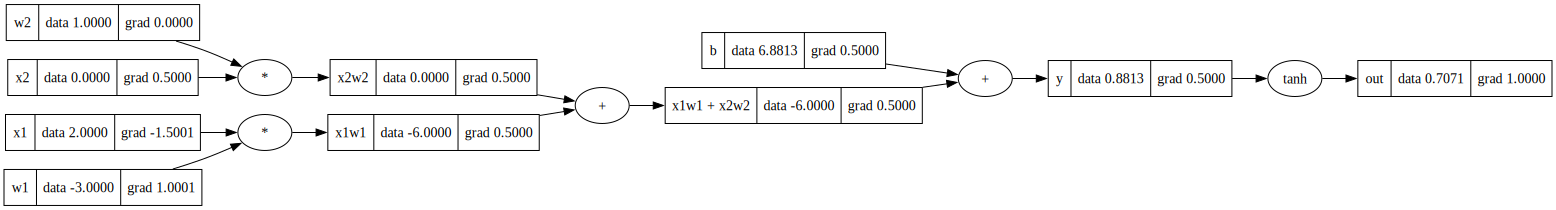

In [23]:
# Calculate Gradients
out.grad = 1.0  # Base case

# Tanh
y.grad = out.grad * (1 - out.data**2)

# Sum: Add the gradients of the output of each node to each node
sum_x1w1_x2w2.grad = y.grad
b.grad = sum_x1w1_x2w2.grad
x1w1.grad = sum_x1w1_x2w2.grad
x2w2.grad = sum_x1w1_x2w2.grad

# Multiplication: Multiply the gradient of the output by the gradient of the other input
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data
# Inputs: Optional
x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data

draw_dot(out)

#### Calculate gradients using the custom class method


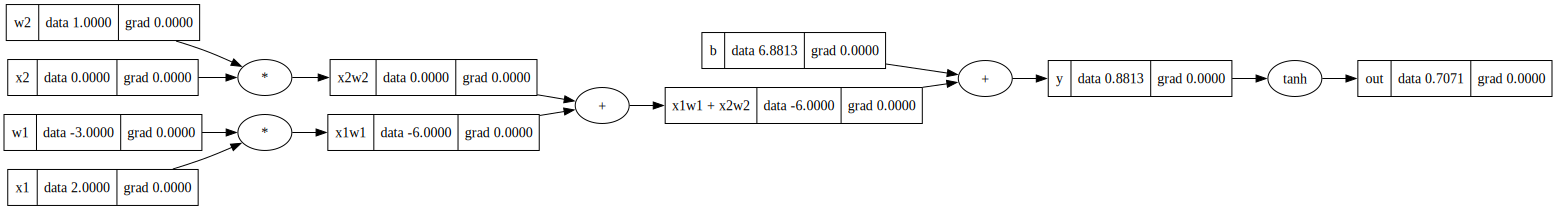

In [24]:
[out, y, sum_x1w1_x2w2, x1w1, x2w2, b, x1, x2, w1, w2, b] = create_graph()

draw_dot(out)

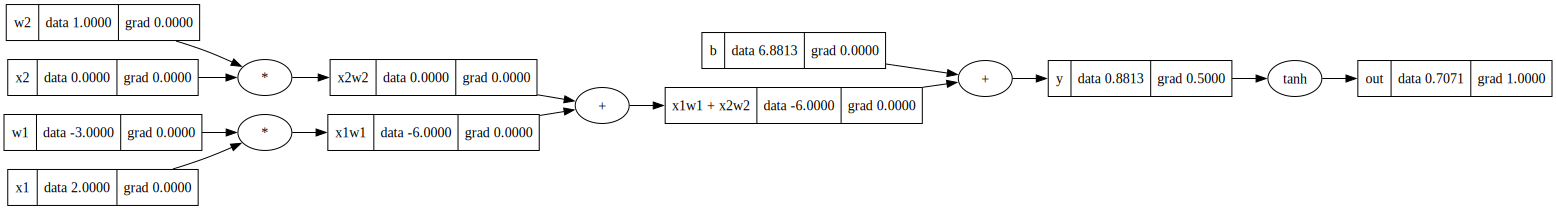

In [25]:
out.grad = 1.0  # Base case
out._backward()

draw_dot(out)

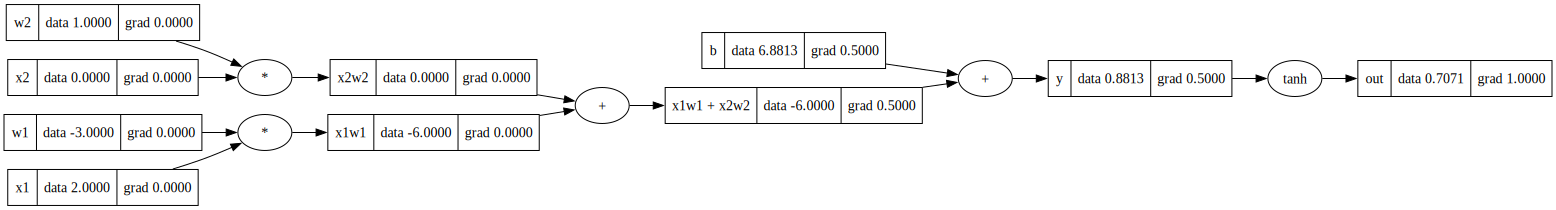

In [26]:
y._backward()

draw_dot(out)

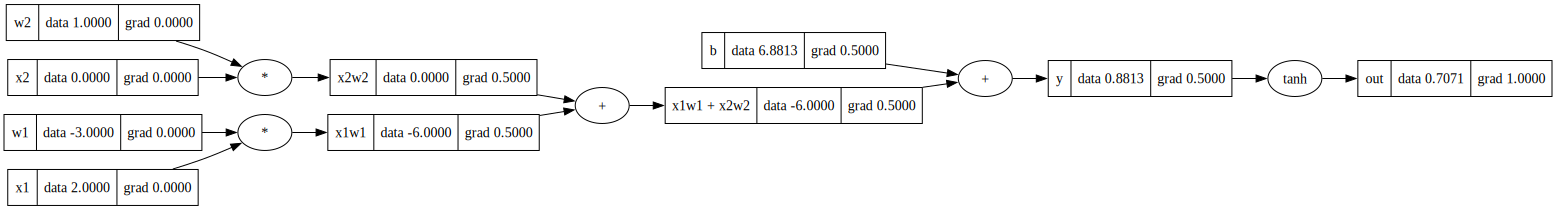

In [27]:
sum_x1w1_x2w2._backward()
b._backward()

draw_dot(out)

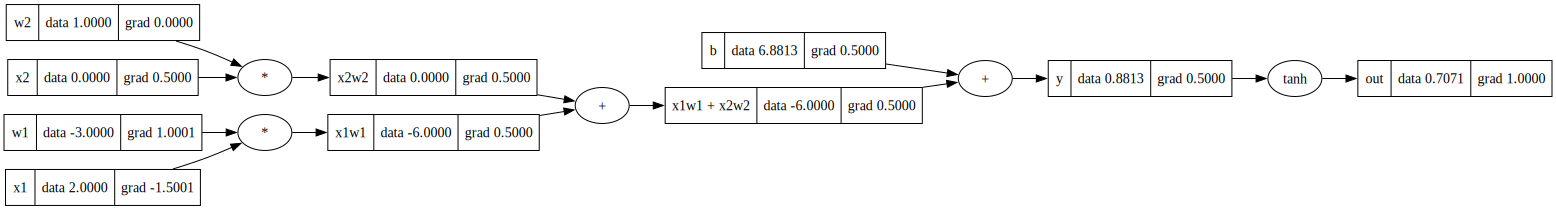

In [28]:
x1w1._backward()
x2w2._backward()

draw_dot(out)

### Implement The BackProp Without Calling It Manually

- Using topological sort.

In [29]:
def build_topology(
    node: Value, topology: list[Any] = [], visited: set[Any] = set()
) -> list[Any]:
    """Builds a topological ordering of the nodes in a directed acyclic graph (DAG).

    Params:
    -------
        node (Value): The root node of the DAG.

    Returns:
    --------
        list[Any]: A list of nodes in topological order.
    """

    if node not in visited:
        visited.add(node)
        for child in node._prev:
            build_topology(child)
        topology.append(node)
    return topology

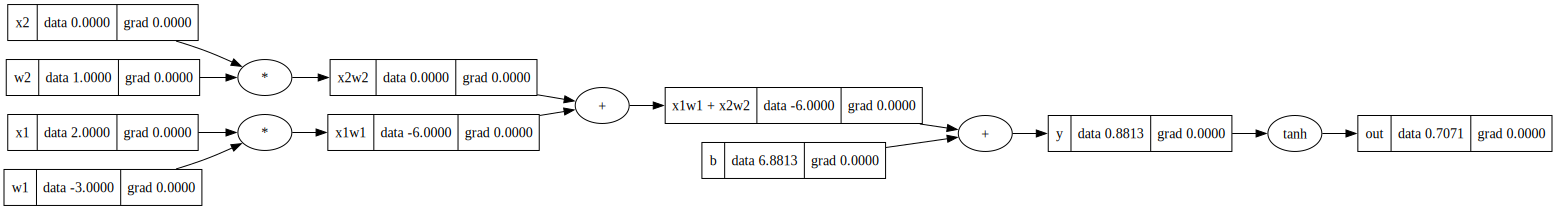

In [30]:
[out, y, sum_x1w1_x2w2, x1w1, x2w2, b, x1, x2, w1, w2, b] = create_graph()

draw_dot(out)

In [31]:
nodes: list[Any] = build_topology(node=out)
nodes

[Value(data=6.88131),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.88131),
 Value(data=0.707074986247229)]

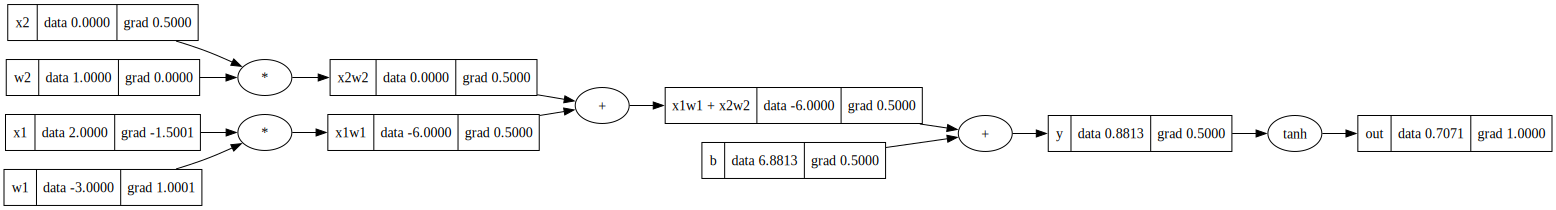

In [32]:
# Apply backprop to all the nodes in the network, starting from the output node.
out.grad = 1.0  # Base case
for node in reversed(nodes):
    node._backward()

draw_dot(out)